# Sentiment analysis on Twitter Data pertaining to Airlines
## Using CountVectorizer, Logistic Regression and Multinomial Naive Bayes modules

Note: If you running it, please run from top-to-bottom manner, as variable names have been replicated for scalability and depend on previous step

## Importing relevant libraries

In [108]:
#For General purpose
import os
import json
import time

#For Math calculations and data manipulations 
import numpy as np
import pandas as pd
import re
from scipy import stats

#For Machine learning algos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

#For Plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True)

#Other
import warnings
warnings.filterwarnings("ignore")

## 1- Loading all tweets, and Plot sentiment distribution for each airline

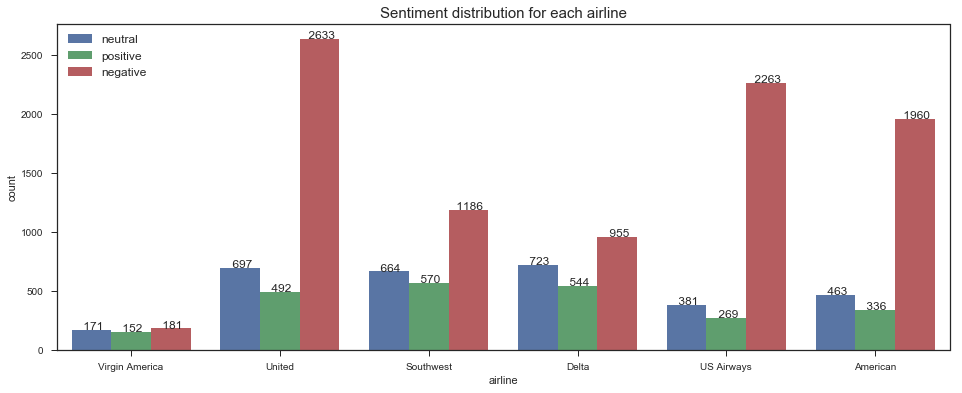

In [109]:
#Loading data
Tweets_df = pd.read_csv("Tweets.csv", header=0, delimiter=",", quoting=0)
Tweets_df = Tweets_df[['airline_sentiment','airline','text']]

#Plotting data
plt.figure(figsize=(16,6))
ax=sns.countplot(x='airline', hue="airline_sentiment",data=Tweets_df)
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x()+p.get_width()/2., height + 3,'{: d}'.format(height), ha="center")
plt.title("Sentiment distribution for each airline",size=15)
plt.legend(fontsize='medium',loc='upper left')
plt.show()

 
Little imbalanced class distibution for United, US Airways, American airlines (might create a problem in interpreting accuracy as the measure of predictibility)

## 2 - Removing URLs and mentions and rename hashtag sign to ‘hashtag_’. Vectorizing tweets using count vectorization.

In [110]:
#General - Creating pattern objects for URL, mentions(@), hastag(#), tokens(size2)
pattern_url = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', re.UNICODE | re.IGNORECASE)
pattern_mention = re.compile('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)', re.UNICODE | re.IGNORECASE)
pattern_hashtag = re.compile('(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)', re.UNICODE | re.IGNORECASE)
pattern_token = re.compile('\w\w+', re.UNICODE | re.IGNORECASE)

#Removing URLs(in first or innermost list comprehension operation) and mentions(in second operation)
temp1a = [pattern_mention.sub('', item) for item in [pattern_url.sub('', item) for item in Tweets_df['text']]]

#Renaming hashtags(#) to hashtag_
text_clean = [pattern_hashtag.sub(r'hashtag_\1', item) for item in temp1a]

#Vectorizing using CountVectorizer
CntVect = CountVectorizer(min_df = 5, stop_words = 'english')
text_clean_CntVect = CntVect.fit_transform(text_clean)

#Storing CntVect results in pandas DF (for future use in Q5)
df=pd.DataFrame(text_clean_CntVect.toarray(),columns=CntVect.get_feature_names()) 

## 3 - Each airline, Logistic Regression & validation using 10-fold CV (Accuracy & F1-score)

**Preprocessing data for next processes (Q3 and Q4)**

In [111]:
#Renaming 'airline' named column as it would occurs in data and CntVect data
Tweets_df.rename(columns={'airline':'airline_main'},inplace=True)

#Joining text_clean and removing text from data
Tweets_df['text_clean']=text_clean
Tweets_df.drop('text',axis=1,inplace=True)

#LabelCoding for y variable
labelencoding=LabelEncoder()
Tweets_df.iloc[:,0]=labelencoding.fit_transform(Tweets_df.iloc[:,0])

**Building 10-fold CV based Logistic Regression Model for each airlines respectively (along with Evaluation metrics)**

In [112]:
#For-loop to iterate over different airlines
scores=[]
top_words=[]
for airline in list(set(Tweets_df['airline_main'])):
    
    #Subsetting data for each airline and storing in temp 'ADS' data for further analysis
    ADS=Tweets_df[Tweets_df['airline_main']==airline]
    
    #Reseting indices of data
    ADS.reset_index(inplace=True)
    
    #Segregating ADS into ADS_X (value array) and ADS_y (value array)
    ADS_X=ADS.iloc[:,3].values
    ADS_y=ADS.iloc[:,1].values
    
    #K-fold validation
    kf = KFold(n_splits=10,random_state=577)
    fold=1
    for train, valid in kf.split(ADS_X,ADS_y):
        
        #Splitting data into K-folds based on assigned indiecs
        X_train_text, y_train = ADS_X[train], ADS_y[train]
        X_valid_text, y_valid = ADS_X[valid], ADS_y[valid]
        
        #Vectorizing our data with CountVectorizer
        CntVect_LR = CountVectorizer(min_df = 5, stop_words = 'english')
        X_train = CntVect_LR.fit_transform(X_train_text)
        X_valid = CntVect_LR.transform(X_valid_text)
        
        #Hyper-parameter tuning (naive way - just to get an idea of what could be a good hyperparamter)
        Accuracy = []
        F1score = []
        C = np.linspace(.001, 5, 50)
        
        #Hyperparametr tuning
        for c in C:
            LR = LogisticRegression(C = c, n_jobs=-1)
            LR.fit(X_train, y_train)
            p_valid = LR.predict(X_valid)
            Accuracy.append({'C': c, 'accuracy': accuracy_score(y_valid, p_valid)})
            F1score.append({'C': c, 'f1_score': f1_score(y_valid, p_valid, average='weighted')})

        #SToring results from above for loop for hyperparam tuning in pandas DF
        Accuracy=pd.DataFrame(Accuracy)
        F1score=pd.DataFrame(F1score)
        
        #C for max accuracy or F-score (w.r.t validation data) is    
        best_C_acc=Accuracy.groupby(['C'])['accuracy'].mean().argmax()
        best_C_F1=F1score.groupby(['C'])['f1_score'].mean().argmax()
        
        #Building Multi-log reg model; then fitting on data; 
        LR = LogisticRegression(C = best_C_acc, multi_class='ovr', n_jobs=-1)
        LR.fit(X_train, y_train.ravel())
        
        #Fitting models params on validation data
        p_valid = LR.predict(X_valid)
    
        #Recording and storing Evaluation metrics
        accuracy=accuracy_score(y_valid, p_valid)
        F1scr_wt=f1_score(y_valid, p_valid, average='weighted')
        scores.append([airline, fold, best_C_acc, accuracy, F1scr_wt])
        
        #Recording and storing top driving words for respective sentiments 
        vocab = np.array(CntVect_LR.get_feature_names())
        order_neg = LR.coef_[0].argsort()
        order_neu = LR.coef_[1].argsort()
        order_pos = LR.coef_[2].argsort()
        top_words.append({'airline': airline, 
                          'fold': fold,
                          "Negative": vocab[order_neg[-1:][0]],
                          "Positive": vocab[order_pos[-1:][0]],
                          "Neutral": vocab[order_neu[-1:][0]]})
        
        #print({"Negative": vocab[order_neg[-10:][::-1]], "Positive": vocab[order_pos[-10:][::-1]],"Neutral": vocab[order_neu[-10:][::-1]]})
        fold=fold+1
    
#Storing Evaluation metrics in pandas DF; then summarizing it for each airline    
scores=pd.DataFrame(scores,columns=['airline', 'fold', 'best_C_acc','accuracy', 'F1_score_wt'])
print('\nEVALUATION USING 10-FOLD CV--------------------')
print(scores.groupby(['airline'])['best_C_acc', 'accuracy','F1_score_wt'].mean())
                          
#Storing and Publishing top sentiment words
top_words=pd.DataFrame(top_words)
print('\nTOP WORDS(for resp. class)----------------------')
print(top_words.groupby(['airline']).agg({'Positive': lambda x:stats.mode(x)[0], 
                                          'Negative': lambda x:stats.mode(x)[0],
                                          'Neutral': lambda x:stats.mode(x)[0]}))


EVALUATION USING 10-FOLD CV--------------------
                best_C_acc  accuracy  F1_score_wt
airline                                          
American          1.276255  0.791970     0.762265
Delta             1.011002  0.682754     0.679377
Southwest         0.980396  0.710744     0.707055
US Airways        1.123224  0.820817     0.786717
United            0.908982  0.765563     0.741048
Virgin America    1.011002  0.642824     0.648485

TOP WORDS(for resp. class)----------------------
               Positive Negative    Neutral
airline                                    
American          thank     days  traveling
Delta            thanks  delayed         hi
Southwest         thank     hold   possible
US Airways        thank    hours         dm
United            thank    worst         hi
Virgin America   thanks  website       help


#### ANALYSIS OF ABOVE RESULT---------------------------------------------------------------------------------------------##
Each airline seems to have a different set of joint distribution of sentiments (class label vector) and words in corresponding tweets' text (count vectorizer matrix). It could be seen from following:

a. Accuracy and F1_scores metrics are both reliable for airlines like Virgin America, South West and Delta as the sentiment classes are balanced for these airlines), but for US Airways, American, United airlines, F1_scores should be more appropriate (as accuracy is usually not the right meausure for imbalanced class which seem to be a case here)

b. Top words that the respective sentiments (based on parameter estimates after training) are captured by finding the mode of the word distribution across folds and are pretty intuitive. Although the top positive word for all airlines seems to be the same "thanks" and synonyms, after looking into the vector of words corresponding to the sentiments, they do look similar in sense but still distinct words.

#### -------------------------------------------------------------------------------------------------------------------------------##

## 4 - Each airline, Naive Bayes Classifier & validation using 10-fold CV (Accuracy & F1-score)

**Building 10-fold CV based Naive Bayes Classifier for each airlines respectively (along with Evaluation metrics)**

In [113]:
#For-loop to iterate over different airlines
scores=[]
top_words=[]
for airline in list(set(Tweets_df['airline_main'])):
    
    #Subsetting data for each airline and storing in temp 'ADS' data for further analysis
    ADS=Tweets_df[Tweets_df['airline_main']==airline]
    
    #Reseting indices of data
    ADS.reset_index(inplace=True)
    
    #Segregating ADS into ADS_X (value array) and ADS_y (value array)
    ADS_X=ADS.iloc[:,3].values
    ADS_y=ADS.iloc[:,1].values
    
    #K-fold validation
    kf = KFold(n_splits=10,random_state=577)
    fold=1
    for train, valid in kf.split(ADS_X,ADS_y):
        
        #Splitting data into K-folds based on assigned indiecs
        X_train_text, y_train = ADS_X[train], ADS_y[train]
        X_valid_text, y_valid = ADS_X[valid], ADS_y[valid]
        
        #Vectorizing our data with CountVectorizer
        CntVect_MNB = CountVectorizer(min_df = 5, stop_words = 'english')
        X_train = CntVect_MNB.fit_transform(X_train_text)
        X_valid = CntVect_MNB.transform(X_valid_text)
        
        #Hyper-parameter tuning (naive way - just to get an idea of what could be a good hyperparamter)
        Accuracy = []
        F1score = []
        ALPHA = np.linspace(.001, 5, 100)
        
        #Hyperparametr tuning
        for alpha in ALPHA:
            MNB = MultinomialNB(alpha)
            MNB.fit(X_train, y_train)
            p_valid = MNB.predict(X_valid)
            Accuracy.append({'ALPHA': alpha, 'accuracy': accuracy_score(y_valid, p_valid)})
            F1score.append({'ALPHA': alpha, 'f1_score': f1_score(y_valid, p_valid, average='weighted')})

        #SToring results in pandas DF
        Accuracy=pd.DataFrame(Accuracy)
        F1score=pd.DataFrame(F1score)
        
        #alpha for max accuracy or F-score (w.r.t validation data) is    
        best_alpha_acc=Accuracy.groupby(['ALPHA'])['accuracy'].mean().argmax()
        best_alpha_F1=F1score.groupby(['ALPHA'])['f1_score'].mean().argmax()
        
        #Building Multi-log reg model; then fitting on data; 
        MNB = MultinomialNB(best_alpha_acc)
        MNB.fit(X_train, y_train.ravel())
        
        #Fitting models params on validation data
        p_valid = MNB.predict(X_valid)
    
        #Recording and storing Evaluation metrics
        accuracy=accuracy_score(y_valid, p_valid)
        F1scr_wt=f1_score(y_valid, p_valid, average='weighted')
        scores.append([airline, fold, best_alpha_acc, accuracy, F1scr_wt])
        
        #Recording and storing top driving words for respective sentiments 
        vocab = np.array(CntVect_MNB.get_feature_names())
        order_neg = MNB.coef_[0].argsort()
        order_neu = MNB.coef_[1].argsort()
        order_pos = MNB.coef_[2].argsort()
        top_words.append({'airline': airline, 
                          'fold': fold,
                          "Negative": vocab[order_neg[-1:][0]],
                          "Positive": vocab[order_pos[-1:][0]],
                          "Neutral": vocab[order_neu[-1:][0]]})
        
        #print({"Negative": vocab[order_neg[-10:][::-1]], "Positive": vocab[order_pos[-10:][::-1]],"Neutral": vocab[order_neu[-10:][::-1]]})
        fold=fold+1
    
#Storing Evaluation metrics in pandas DF; then summarizing it for each airline    
scores=pd.DataFrame(scores,columns=['airline', 'fold', 'best_alpha_acc','accuracy', 'F1_score_wt'])
print('\nEVALUATION USING 10-FOLD CV--------------------')
print(scores.groupby(['airline'])['best_alpha_acc', 'accuracy','F1_score_wt'].mean())
                          
#Storing and Publishing top sentiment words
top_words=pd.DataFrame(top_words)
print('\nTOP WORDS(for resp. class)----------------------')
print(top_words.groupby(['airline']).agg({'Positive': lambda x:stats.mode(x)[0], 
                                          'Negative': lambda x:stats.mode(x)[0],
                                          'Neutral': lambda x:stats.mode(x)[0]}))


EVALUATION USING 10-FOLD CV--------------------
                best_alpha_acc  accuracy  F1_score_wt
airline                                              
American              1.399710  0.773120     0.747538
Delta                 1.813769  0.671052     0.657803
Southwest             1.530997  0.700826     0.693857
US Airways            0.914959  0.813263     0.789229
United                1.233077  0.752744     0.733246
Virgin America        1.313869  0.533647     0.526986

TOP WORDS(for resp. class)----------------------
               Positive Negative Neutral
airline                                 
American         thanks   flight  flight
Delta            thanks   flight   fleek
Southwest        thanks   flight  flight
US Airways       thanks   flight  flight
United           thanks   flight  flight
Virgin America   flight   flight  flight


#### ANALYSIS OF ABOVE RESULT---------------------------------------------------------------------------------------------##
Again, each airline seems to have a different set of joint distribution of sentiments (class label vector) and words in corresponding tweets' text (count vectorizer matrix). Also, the Naive Bayes models seems to pick up a slightly different aspects of this joint distribution than Logistic Regression, which could be seen from following:

a. Accuracy and F1_scores metrics are both less for each airline as compared to Logistic Regression results. Although, again, accuracy values reliable for airlines like Virgin America, South West and Delta as the sentiment classes are balanced for these airlines, but for US Airways, American, United airlines, F1_scores should be more appropriate (as accuracy is usually not the right meausure for imbalanced class which seem to be a case here)

b. Top words that the Nagative and Neutral sentiments (based on parameter estimates after training) correspond to, for each airline are different from that of Logistics'. Although the top positive word for all airlines seems to be the same "thanks" and synonyms for these models. Negative sentiment's top word don't make much sense. Also, after looking into the vector of words corresponding to the sentiments, they do look similar in sense but still distinct words.

#### -------------------------------------------------------------------------------------------------------------------------------##


## 5 - All airlines, build above models & validation using 10-fold CV (Accuracy & F1-score)

**Building the analytical dataset for analysis (Concatenating with CntVect data & Dummy variable creation for 'airline_main' column)**

In [114]:
#Concatenating originally Tweet-data with CntVect data 'df' created in Q2 => y + airline + CntVect transformed data 
ADS_airline_tweets = pd.concat([Tweets_df, df], axis=1, join_axes=[Tweets_df.index]).drop('text_clean',1)

#Creating dummry variables for airline; 
ADS_airline_tweets_1 = pd.get_dummies(ADS_airline_tweets,columns=['airline_main'])

### LOGISTIC REGRESSION
**Model Performance on validaiton data w.r.t. Hyperparameter (getting an idea about the effect of hyperparameter on model performance)**
    Note: This search could be further sophisticated using nested CV loops

Best C corresponding to highest accuracy: [ 0.30706122]
Best C corresponding to highest F1score: [ 0.30706122]


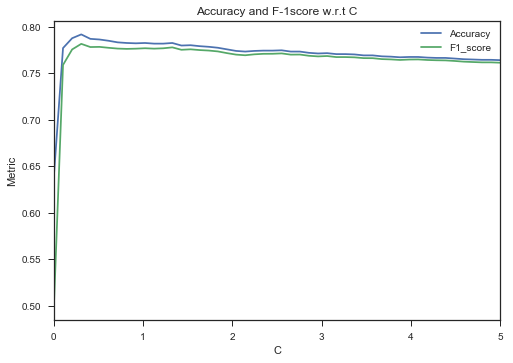

In [115]:
#Segregating ADS into ADS_X (value array) and ADS_y (value array)
ADS_X=ADS_airline_tweets_1.iloc[:,1:].values
ADS_y=ADS_airline_tweets_1.iloc[:,0].values

#Splitting data into test and train
X_train, X_valid, y_train, y_valid = train_test_split(ADS_X, ADS_y, test_size=0.20, random_state=566)

#Hyper-parameter tuning (naive way - just to get an idea of what could be a good hyperparamter)
Accuracy = []
F1score = []
C = np.linspace(.001, 5, 50)

for c in C:
    LR = LogisticRegression(C = c, n_jobs=-1)
    LR.fit(X_train, y_train)
    p_valid = LR.predict(X_valid)
    Accuracy.append(accuracy_score(y_valid, p_valid))
    F1score.append(f1_score(y_valid, p_valid, average='weighted'))

#C for max accuracy or F-score (w.r.t validation data) is    
print('Best C corresponding to highest accuracy:', C[Accuracy==max(Accuracy)])
print('Best C corresponding to highest F1score:',C[F1score==max(F1score)])

#Plotting behaviour of Model performance on validation data w.r.t C
plt.title("Accuracy and F-1score w.r.t C")
plt.plot(C, Accuracy, label='Accuracy')
plt.plot(C, F1score, label='F1_score')
plt.xlabel('C')
plt.ylabel('Metric')
plt.xlim(0, max(C))
plt.legend(loc='best')
plt.show()

**Building 10-fold CV based Logistic Regression Model (with optimal hyperparameter from above) for all airlines respectively (with Evaluation metrics)**

In [116]:
#Intialising vectors to store results and top words for each sentiment
scores=[]
top_features=[]
    
#Segregating ADS into ADS_X (value array) and ADS_y (value array)
ADS_X=ADS_airline_tweets_1.iloc[:,1:].values
ADS_y=ADS_airline_tweets_1.iloc[:,0].values

#K-fold validation
kf = KFold(n_splits=10,random_state=577)
fold=1
for train, valid in kf.split(ADS_X,ADS_y):

    #Splitting data into K-folds based on assigned indiecs
    X_train, y_train = ADS_X[train], ADS_y[train]
    X_valid, y_valid = ADS_X[valid], ADS_y[valid]

    #Building Multi-log reg model; then fitting on data; 
    LR = LogisticRegression(C = C[Accuracy==max(Accuracy)][0], multi_class='ovr', n_jobs=-1)
    LR.fit(X_train, y_train)

    #Fitting models params on validation data
    p_valid = LR.predict(X_valid)

    #Recording and storing Evaluation metrics
    accuracy=accuracy_score(y_valid, p_valid)
    F1scr_wt=f1_score(y_valid, p_valid, average='weighted')
    scores.append([fold, accuracy, F1scr_wt])

    #Recording and storing top driving words for respective sentiments 
    top_features.append({'fold': fold,
                         "Negative": list(ADS_airline_tweets_1.columns[1:][LR.coef_[0].argsort()][-3:][::-1])[0],
                         "Positive": list(ADS_airline_tweets_1.columns[1:][LR.coef_[2].argsort()][-3:][::-1])[0],
                         "Neutral": list(ADS_airline_tweets_1.columns[1:][LR.coef_[1].argsort()][-3:][::-1])[0]})

    #print({"Negative": list(ADS_airline_tweets_1.columns[1:][LR.coef_[0].argsort()][-10:][::-1]), "Positive": list(ADS_airline_tweets_1.columns[1:][LR.coef_[2].argsort()][-10:][::-1]),"Neutral": list(ADS_airline_tweets_1.columns[1:][LR.coef_[1].argsort()][-10:][::-1])})
    fold=fold+1

#Storing Evaluation metrics in pandas DF; then summarizing it for each airline    
scores=pd.DataFrame(scores,columns=['fold', 'accuracy', 'F1_score_wt'])
print('\nEVALUATION USING 10-FOLD CV--------------------')
print(scores[['accuracy','F1_score_wt']].mean())
                          
#Storing and Publishing top features
top_features=pd.DataFrame(top_features)
print('\nTOP FEATURES(for resp. class)----------------------')
print('Positive:', stats.mode(top_features['Positive'])[0][0])
print('Negative:', stats.mode(top_features['Negative'])[0][0])
print('Neutral:', stats.mode(top_features['Neutral'])[0][0])


EVALUATION USING 10-FOLD CV--------------------
accuracy       0.772063
F1_score_wt    0.756436
dtype: float64

TOP FEATURES(for resp. class)----------------------
Positive: thank
Negative: worst
Neutral: hi


#### ANALYSIS OF ABOVE RESULT---------------------------------------------------------------------------------------------##
The joint distribution of sentiments (class label vector) and words in corresponding tweets' text (count vectorizer matrix) is captured by this slightly optimized model by around 75%. It could be seen from following:

a. Top words that the respective sentiments (based on parameter estimates after training) are captured by finding the mode of the word distribution across folds. After looking into the vector of words corresponding to the sentiments in each loop, they do look similar in sense but still distinct words (and also the airline itself comes into action for defining the sentiment)

b. In hyperparameter tuning (graph above), accuracy value seems to be peaking at around C=(0.3-0.4) and then declines. Note: Again this process involves just one test-validation split and could be further optimized using nested cross-validation, but intutively the hyperparameter should move about the value considering data is consistent 
#### -------------------------------------------------------------------------------------------------------------------------------##




### NAIVE BAYES
**Model Performance on validaiton data w.r.t. Hyperparameter (getting an idea about the effect of hyperparameter)** Note: This search could be further sophisticated using nested CV loops along with a grid search

Best alpha corresponding to highest accuracy: [ 0.3039697]
Best alpha corresponding to highest F1score: [ 0.3039697]


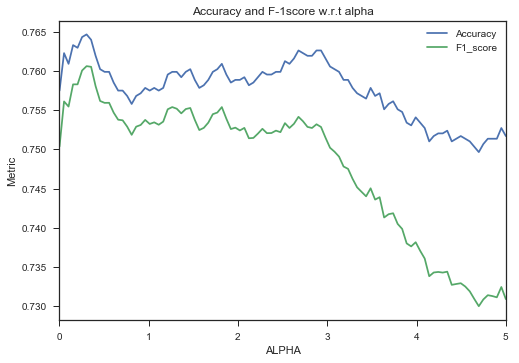

In [117]:
#Segregating ADS into ADS_X (value array) and ADS_y (value array)
ADS_X=ADS_airline_tweets_1.iloc[:,1:].values
ADS_y=ADS_airline_tweets_1.iloc[:,0].values

#Splitting data into test and train
X_train, X_valid, y_train, y_valid = train_test_split(ADS_X, ADS_y, test_size=0.20, random_state=566)

#Hyper-parameter tuning (naive way - just to get an idea of what could be a good hyperparamter)
Accuracy = []
F1score = []
ALPHA = np.linspace(.001, 5, 100)

for alpha in ALPHA:
    MNB = MultinomialNB(alpha)
    MNB.fit(X_train, y_train)
    p_valid = MNB.predict(X_valid)
    Accuracy.append(accuracy_score(y_valid, p_valid))
    F1score.append(f1_score(y_valid, p_valid, average='weighted'))

#alpha for max accuracy or F-score (w.r.t validation data) is    
print('Best alpha corresponding to highest accuracy:', ALPHA[Accuracy==max(Accuracy)])
print('Best alpha corresponding to highest F1score:', ALPHA[F1score==max(F1score)])

#Plotting behaviour of Model performance on validation data w.r.t alpha    
plt.title("Accuracy and F-1score w.r.t alpha")
plt.plot(ALPHA, Accuracy, label='Accuracy')
plt.plot(ALPHA, F1score, label='F1_score')
plt.xlabel('ALPHA')
plt.ylabel('Metric')
plt.xlim(0, max(ALPHA))
plt.legend(loc='best')
plt.show()

**Building 10-fold CV based Naive Bayes Classifier for all airlines respectively (along with Evaluation metrics)**

In [118]:
#Intialising vectors to store results and top words for each sentiment
scores=[]
top_features=[]
    
#Segregating ADS into ADS_X (value array) and ADS_y (value array)
ADS_X=ADS_airline_tweets_1.iloc[:,1:].values
ADS_y=ADS_airline_tweets_1.iloc[:,0].values

#K-fold validation
kf = KFold(n_splits=10,random_state=577)
fold=1
for train, valid in kf.split(ADS_X,ADS_y):

    #Splitting data into K-folds based on assigned indiecs
    X_train, y_train = ADS_X[train], ADS_y[train]
    X_valid, y_valid = ADS_X[valid], ADS_y[valid]

    #Building Multinomial Naive Bayes model; then fitting on data; 
    MNB = MultinomialNB(ALPHA[Accuracy==max(Accuracy)][0])
    MNB.fit(X_train, y_train)

    #Fitting models params on validation data
    p_valid = MNB.predict(X_valid) 

    #Recording and storing Evaluation metrics
    accuracy=accuracy_score(y_valid, p_valid)
    F1scr_wt=f1_score(y_valid, p_valid, average='weighted')
    scores.append([fold, accuracy, F1scr_wt])

    #Recording and storing top driving words for respective sentiments 
    top_features.append({'fold': fold,
                         "Negative": list(ADS_airline_tweets_1.columns[1:][MNB.coef_[0].argsort()][-3:][::-1])[0],
                         "Positive": list(ADS_airline_tweets_1.columns[1:][MNB.coef_[2].argsort()][-3:][::-1])[0],
                         "Neutral": list(ADS_airline_tweets_1.columns[1:][MNB.coef_[1].argsort()][-3:][::-1])[0]})

    #print({"Negative": list(ADS_airline_tweets_1.columns[1:][LR.coef_[0].argsort()][-10:][::-1]), "Positive": list(ADS_airline_tweets_1.columns[1:][LR.coef_[2].argsort()][-10:][::-1]),"Neutral": list(ADS_airline_tweets_1.columns[1:][LR.coef_[1].argsort()][-10:][::-1])})
    fold=fold+1

#Storing Evaluation metrics in pandas DF; then summarizing it for each airline    
scores=pd.DataFrame(scores,columns=['fold', 'accuracy', 'F1_score_wt'])
print('\nEVALUATION USING 10-FOLD CV------------------------')
print(scores[['accuracy','F1_score_wt']].mean())
                          
#Storing and Publishing top features
top_features=pd.DataFrame(top_features)
print('\nTOP FEATURES (for resp. class)----------------------')
print('Positive:', stats.mode(top_features['Positive'])[0][0])
print('Negative:', stats.mode(top_features['Negative'])[0][0])
print('Neutral:', stats.mode(top_features['Neutral'])[0][0])


EVALUATION USING 10-FOLD CV------------------------
accuracy       0.753347
F1_score_wt    0.746159
dtype: float64

TOP FEATURES (for resp. class)----------------------
Positive: airline_main_Southwest
Negative: flight
Neutral: airline_main_Delta


#### ANALYSIS OF ABOVE RESULT---------------------------------------------------------------------------------------------##
The joint distribution of sentiments (class label vector) and words in corresponding tweets' text (count vectorizer matrix) is captured by this slightly optimized model by around 75% (a little less better than Logistic). It could be seen from following:

a. Top words that the respective sentiments (based on parameter estimates after training) are captured by finding the mode of the word distribution across folds. This models seems to capture the airline itself affecting the sentiment (may be because of the unpopularity gained over time playing around). After looking into the vector of words corresponding to the sentiments in each loop, they do look similar in sense but still distinct words (and also )

b. In hyperparameter tuning (graph above), accuracy value seems to be peaking at around alpha=(0.3-0.4) and then declines. Note: Again this process involves just one test-validation split and could be further optimized using nested cross-validation, but intutively the hyperparameter should move about the value considering data is consistent
#### -------------------------------------------------------------------------------------------------------------------------------##


## 6 - Generate a learning curve by gradually adding training data  and Plotting the accuracy of logistic regression and multinomial Naïve Bayes 

**Splitting joined data into (Train, validation) in the ratio of 80:20 **

In [119]:
X_train, X_valid, y_train, y_valid = train_test_split(ADS_X, ADS_y, test_size=0.20, random_state=566)

**Building models with increasing % of training data**

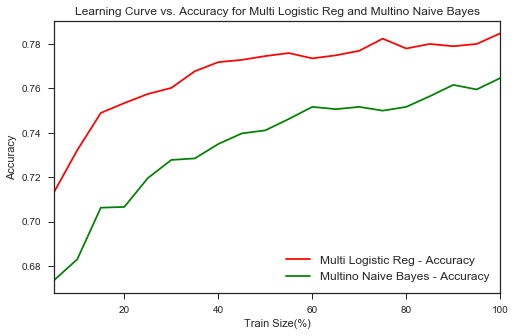

In [120]:
results = []
for i in np.arange(0.05,1.05,0.05):
    nrows=int(round(X_train.shape[0]*i))
    X_train_in=X_train[:nrows]
    y_train_in=y_train[:nrows]
    
    #---Building models; then fitting on data; 
    #Multi-Logistic
    LR = LogisticRegression(C=C[Accuracy==max(Accuracy)][0], multi_class='ovr', n_jobs=-1)
    LR.fit(X_train_in, y_train_in)
    
    #Multinomial Naive Bayes 
    MNB = MultinomialNB(ALPHA[Accuracy==max(Accuracy)][0])
    MNB.fit(X_train_in, y_train_in)

    #Fitting models params on validation data
    p_valid_LR = LR.predict(X_valid)
    p_valid_MNB = MNB.predict(X_valid)
    
    #Recording and storing Evaluation metrics
    accuracy_LR=accuracy_score(y_valid, p_valid_LR)
    accuracy_MNB=accuracy_score(y_valid, p_valid_MNB)
    
    #Recording and storing top driving words for respective sentiments
    results.append({'train size(%)': round(i*100),
                    'accuracy_LR': accuracy_LR,
                    'accuracy_MNB': accuracy_MNB})
    
results=pd.DataFrame(results)
    
fig=plt.figure(figsize=(8,5))

plt.plot(results['train size(%)'],results['accuracy_LR'], label='Multi Logistic Reg - Accuracy', C='red')
plt.plot(results['train size(%)'],results['accuracy_MNB'], label='Multino Naive Bayes - Accuracy', c='green')

plt.title('Learning Curve vs. Accuracy for Multi Logistic Reg and Multino Naive Bayes',size=12)
plt.xlabel('Train Size(%)')
plt.ylabel('Accuracy')
plt.xlim(results['train size(%)'].min(),results['train size(%)'].max())
plt.legend(loc = 'lower right', fontsize="medium")
plt.show()   

#### ANALYSIS OF ABOVE RESULT---------------------------------------------------------------------------------------------##
This plot goes by the intuition that if the training data is increased, the model is able to learn and capture more info, but it doesnt seem to saturate yet in this given data. There is a possibility that we could get more accuracy if we get more data given my the nature of the graph's acuracy to be increasing at 100%
### ------------------------------------------------------------------------------------------------------------##
